In [2]:
import math
import os
import time
from typing import Union

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch
from torch.cuda.amp import autocast
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.mask_rcnn import MaskRCNN
from tqdm.auto import tqdm as tq

from craterdetection.detection.training import CraterInstanceDataset, collate_fn, load_checkpoint
from craterdetection.detection.visualisation import draw_patches

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("crater-detection")

In [4]:
dataset_path = "../data/dataset_instanced.h5"
train_dataset = CraterInstanceDataset(dataset_path, "training")
train_loader = DataLoader(train_dataset, batch_size=10, num_workers=2, collate_fn=collate_fn, shuffle=True)

validation_dataset = CraterInstanceDataset(dataset_path, "validation")
validation_loader = DataLoader(validation_dataset, batch_size=10, num_workers=0, collate_fn=collate_fn)

test_dataset = CraterInstanceDataset(dataset_path, "test")
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=0, collate_fn=collate_fn, shuffle=True)

In [5]:
NUM_CLASSES = 2

backbone = resnet_fpn_backbone('resnet50', pretrained=True, trainable_layers=5)

model = MaskRCNN(
    backbone=backbone,
    num_classes=NUM_CLASSES,
    min_size=256,
    max_size=256
)
model.cuda()
print()

In [6]:
pretrained = True
checkpoint_path = "../blobs/CraterRCNN_85177d4577044541964809f1ae686a2d.pth"

if pretrained:
    model, checkpoint = load_checkpoint(model, checkpoint_path)
else:
    checkpoint = dict()

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=1e-5, momentum=0.3, weight_decay=1e-6)
optimizer = SGD(params, lr=1e-2, momentum=0.1)
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, factor=0.1)
scheduler = StepLR(optimizer, step_size=10)

In [12]:
try:
    start_e = checkpoint['epoch'] + 1
except KeyError:
    start_e = 1

tracked_params = ('lr', 'momentum', 'weight_decay', 'dampening')

num_epochs = 20

name = "Mask RCNN"
name += " | Pretrained" if pretrained else " | Cold Start"

run_args = dict(run_name=name)

if pretrained:
    try:
        run_id = checkpoint['run_id']
        run_args['run_id'] = run_id
    except KeyError:
        print("No run ID found.")

with mlflow.start_run(**run_args) as run:
    run_id = run.info.run_id
    print(run_id)

    mlflow.log_param('optimizer', type(optimizer).__name__)
    mlflow.log_param('dataset', os.path.basename(dataset_path))

    if pretrained:
        mlflow.log_param('checkpoint_file', os.path.basename(checkpoint_path))

    for tp in tracked_params:
        try:
            mlflow.log_param(tp, optimizer.state_dict()['param_groups'][0][tp])
        except KeyError as err:
            pass

    train_loss_list = []
    valid_loss_list = []

    for e in range(start_e, num_epochs+start_e):
        print(f'\n-----Epoch {e} started-----\n')

        since = time.time()

        train_loss, valid_loss = 0, 0

        model.train()

        bar = tq(train_loader, desc=f"Training [{e}]",
                 postfix={
                     "loss_loss": 0.,
                     "loss_classifier": 0.,
                     "loss_box_reg": 0.,
                     "loss_mask": 0.,
                     "loss_objectness": 0.,
                     "loss_rpn_box_reg": 0
                 })
        for batch, (images, targets) in enumerate(bar, 1):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with autocast():
                loss_dict = model(images, targets)

            loss = sum(l for l in loss_dict.values())

            if not math.isfinite(loss):
                del images, targets
                raise RuntimeError(f"Loss is {loss}, stopping training")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            postfix = dict(loss_total=loss.item())

            for k, v in loss_dict.items():
                postfix[k] = v.item()

            bar.set_postfix(ordered_dict=postfix)

            train_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        train_loss_list.append(train_loss)
        mlflow.log_metric("train_loss", train_loss, step=e)

        with torch.no_grad():
            bar = tq(validation_loader, desc=f"Validation [{e}]",
                     postfix={
                         "loss_total": 0.,
                         "loss_classifier": 0.,
                         "loss_box_reg": 0.,
                         "loss_mask": 0.,
                         "loss_objectness": 0.,
                         "loss_rpn_box_reg": 0
                     })
            for batch, (images, targets) in enumerate(bar, 1):
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                with autocast():
                    loss_dict = model(images, targets)

                loss = sum(l for l in loss_dict.values())

                if not math.isfinite(loss):
                    del images, targets
                    raise RuntimeError(f"Loss is {loss}, stopping validation")

                postfix = dict(loss_total=loss.item())

                for k, v in loss_dict.items():
                    postfix[k] = v.item()

                bar.set_postfix(ordered_dict=postfix)

                valid_loss += loss.item()

        # calculate average losses
        valid_loss = valid_loss/len(validation_loader)
        valid_loss_list.append(valid_loss)

        mlflow.log_metric("valid_loss", valid_loss, step=e)

        time_elapsed = time.time() - since
        scheduler.step()

        checkpoint_path = f"../blobs/CraterRCNN_{run_id}.pth"

        torch.save(
            {
                'epoch': e,
                'run_id': run_id,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'avg_train_losses': train_loss_list,
                'avg_val_losses': valid_loss_list
            },
            checkpoint_path
        )

        mlflow.log_artifacts("checkpoint", artifact_path=checkpoint_path)

        model.eval()
        with torch.no_grad():
            images, targets = next(iter(test_loader))
            images = list(image.cuda() for image in images)
            targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

            out = model(images)

        min_score = 0.5

        boxes, labels, scores, masks = map(lambda x: x.cpu(), out[0].values())

        fig, axes = plt.subplots(1, 4, figsize=(25, 20))

        axes[0].imshow(images[0][0].cpu().numpy(), cmap='gray')
        axes[1].imshow(torch.sum(targets[0]['masks'], dim=0).clamp(0, 1).cpu().numpy(), cmap='gray')
        axes[2].imshow(torch.sum(out[0]['masks'][scores > min_score], dim=0).clamp(0, 1).cpu().numpy()[0], cmap='gray')
        draw_patches(images[0].cpu(), boxes, labels, scores, masks, min_score=min_score, ax=axes[3])

        mlflow.log_figure(fig, "sample_output.png")

        print(
            f"\nSummary:\n",
            f"\tEpoch: {e}/{num_epochs+start_e}\n",
            f"\tAverage train loss: {train_loss}\n",
            f"\tAverage validation loss: {valid_loss}\n",
            f"\tDuration: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s"
        )
        print(f'-----Epoch {e} finished.-----\n')

85177d4577044541964809f1ae686a2d

-----Epoch 3 started-----



Training [3]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_loss=0, loss_ma…

Validation [3]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…


Summary:
 	Epoch: 3/6
 	Average train loss: 1.7718892266750337
 	Average validation loss: 2.101223340034485
 	Duration: 5m 24s
-----Epoch 3 finished.-----


-----Epoch 4 started-----



Training [4]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_loss=0, loss_ma…

Validation [4]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…


Summary:
 	Epoch: 4/6
 	Average train loss: 1.751316776752472
 	Average validation loss: 1.6961337661743163
 	Duration: 5m 21s
-----Epoch 4 finished.-----


-----Epoch 5 started-----



Training [5]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_loss=0, loss_ma…

Validation [5]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…


Summary:
 	Epoch: 5/6
 	Average train loss: 1.7538506429195404
 	Average validation loss: 1.6947921288013459
 	Duration: 5m 23s
-----Epoch 5 finished.-----



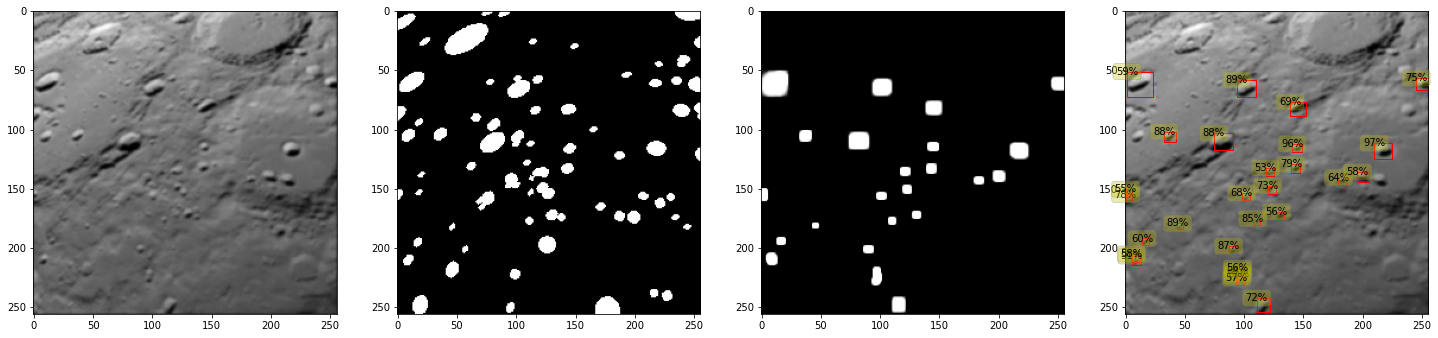